In [1]:
# Installation of the requirements
#!python -m pip install -r requirements.txt

In [1]:
'''
(C) Renata Wong 2023

Qiskit code for testing fidelity of derandomised classical shadow on the ground state energy of molecules. 
This notebook implements an optimization: since the derandomized Hamiltonian may contan very few terms,
instead of generating a quantum circuit for each and measuring once, we generate a single circuit and specify 
a shot number that matches the number of occurrences of a derandomized operator. This speeds up the computation 
significantly. 

Procedure:
1. Derandomize the molecule-in-question's Hamiltonian.
2. Choose a variational ansatz with initial parameters selected at random.
3. Apply the derandomized Hamiltonian as basis change operators to the ansatz.
4. Measure the ansatz in the Pauli Z basis and store the results as a shadow.
5. Obtain the expectation value of the molecular Hamiltonian from the shadow.
6. Optimize for minimum Hamiltonian expectation value. 
7. Feed the calculated angles/parameters back to the ansatz.
8. Repeat steps 3-7 till the optimization is completed. 
9. Output the minimized expectation value of the molecular Hamiltonian and the mean-square-root-error. 

Note: Below we perform calculations on the molecular Hamiltonian of H_2.
To perform calculations on other molecules, you will need to specify their geometry, charge and spin 
to replace the values in the driver. 

To do: Hamiltonian for H_2 on 8 qubits using 6-31G basis.
'''

import numpy as np
import matplotlib.pyplot as plt
import time

from functools import partial

from qiskit.circuit.library import EfficientSU2

from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute

from qiskit.algorithms.optimizers import SLSQP, COBYLA

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from collections import Counter

from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.opflow import I, StateFn, CircuitStateFn

from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp

from modified_derandomization import modified_derandomized_classical_shadow





# SPECIFY THE NUMBER OF EXPERIMENTS YOU WANT TO RUN
num_experiments = 10

# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -1.86



# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)

print(bkenc_hamiltonian)

/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


-0.8105479805373264 * IIII
+ 0.17218393261915543 * IIIZ
- 0.22575349222402474 * IIZZ
+ 0.1209126326177664 * IIZI
+ 0.1721839326191556 * IZII
+ 0.1689275387008791 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
- 0.22575349222402485 * ZZZI
+ 0.1661454325638242 * ZZZZ
+ 0.16614543256382422 * IZZZ
+ 0.1746434306830045 * ZZIZ
+ 0.1209126326177664 * ZIZI


/home/renata/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [2]:
'''
Use classical eigensolver to obtain the ground state energy for the molecule of interest. 
This value is ca. -1.86 and will be used for evaluating the accuracy of the results found by the quantum-classical method.
'''

converter = QubitConverter(BravyiKitaevMapper())
numpy_solver = NumPyMinimumEigensolver()   

calc = GroundStateEigensolver(converter, numpy_solver)
res = calc.solve(problem)
print('Electronic ground state energy found using classical eigensolver:\n', res) 

Electronic ground state energy found using classical eigensolver:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 


/tmp/ipykernel_232/690678606.py:6: DeprecationWarning: The QubitConverter class is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . Instead you should directly use the QubitMapper instance which you used to pass into the QubitConverter as the first argument. Refer to the documentation of the qiskit_nature.second_q.mappers module for more information.
  converter = QubitConverter(BravyiKitaevMapper())


In [2]:
'''
Format Hamiltonian terms and coefficients as required by the package predicting-quantum-properties. 
This includes removing all Pauli-I operators.
'''

hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])

print('All Hamiltonian terms:\n', hamiltonian_terms)
print('All weights:\n', weights)




hamiltonian_terms_XYZE = []

for term in hamiltonian_terms:
    term_XYZE = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZE.append(pauli)
    hamiltonian_terms_XYZE.append(term_XYZE)   
    

abs_weights = [abs(weight) for weight in weights]

hamiltonian_terms_XYZ = []
for idx, term in enumerate(hamiltonian_terms_XYZE):
    if term:
        hamiltonian_terms_XYZ.append(term)
    else:
        abs_weights.pop(idx)
        
print('Hamiltonian terms without Pauli-I:\n', hamiltonian_terms_XYZ)
print('Absolute weights:\n', abs_weights)

All Hamiltonian terms:
 [[('I', 0), ('I', 1), ('I', 2), ('I', 3)], [('I', 0), ('I', 1), ('I', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('I', 2), ('I', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('I', 3)], [('I', 0), ('I', 1), ('Z', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('X', 1), ('I', 2), ('X', 3)], [('I', 0), ('X', 1), ('Z', 2), ('X', 3)], [('Z', 0), ('X', 1), ('Z', 2), ('X', 3)], [('I', 0), ('X', 1), ('I', 2), ('X', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('I', 1), ('Z', 2), ('I', 3)]]
All weights:
 [-0.8105479805373234, 0.1721839326191557, -0.2257534922240249, 0.1721839326191554, -0.22575349222402488, 0.1209126326177664, 0.1689275387008791, 0.04523279994605785, -0.04523279994605785, -0.04523279994605785, 0.04523279994605785, 0.1661454325638242, 0.16614543256382422, 0.1746434306830045, 0.1209126326177664]
Hamiltonian terms w

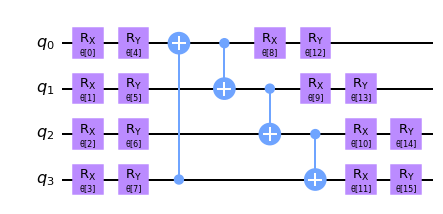

In [3]:
'''
Choose a variational ansatz.
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 1   
ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)  
    
ansatz.decompose().draw('mpl')

In [4]:
'''
Define the cost function = the expectation value of the Hamiltonian H. 
Since the Hamiltonian is processed term by term, the expectation value is composed as follows:
expval(H) = sum_i (weight_i * expval(term_i))
'''


backend = QasmSimulator(method='statevector', shots=1)


# generate a circuit with just a single layer of randomised basis change operators
# this circuit is appended to the ansatz and then measurements are taken in the Pauli-Z basis
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.x(idx)
        elif op == 'Y':
            rand_meas.y(idx)
        elif op == 'Z':
            rand_meas.z(idx)
    return rand_meas



def objective_function(operators, params):
    
    
    # Assign parameters to the ansatz and simulate it
    # Generate circuits to measure random Paulis, one circuit for each Pauli
    
    # Putting repeated operators in derandomized_hamiltonian together and executing one single circuit 
    # as many times as the operator repetitions. 
    
    # convert the inner lists to tuples and count duplicates
    pauli_op_dict = Counter(tuple(x) for x in operators)
    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()
        
        
        # store the shadow in the form [[(Z,1),(Z,-1)...], [(Y,-1),(X,-1),...]] where inner list = snapshot
        # Because measurement output in Qiskit gives us states and not eigenvalues, we need to convert 0->1 and 1->-1
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                shadow.append(snapshot)
    
    
    # Now, we want to get the expectation values for the Hamiltonian from the shadow using the function
    # estimate_exp(full_measurement, one_observable)
    # where full_measurement = shadow and one_observable is any term in the Hamiltonian with I observable excluded.
    # cost = the total expectation value of the Hamiltonian
    # NOTE: We need to check for match_count value since it may happen that it is equal to 0. 
    # Such experiments need to be excluded. 
    # The problem is due to the derandomization algorithm not always producing Paulis that 'hit' the Hamiltonian terms.
    # NOTE: For term = [] we have that sum_product = match_count = len(shadow)
    
    cost = 0.0

    for term, weight in zip(hamiltonian_terms_XYZE, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost = cost + (weight * exp_val)     
        
    cost_history.append(cost)

        
    return cost


In [5]:
'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510 for the size of 1000 operators. 
'''



start_time = time.time()

print('NUMBER OF OPERATORS - OPERATORS - AVERAGE ERROR')

measurement_range = [1, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:    

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)


    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        #print("GROUND STATE ENERGY FOUND = ", min(cost_history))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('{} - {} - {}'.format(num_operators, counts, rmse_derandomised_cs))
    print('EXPECTATION VALUES ', *expectation_values)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


NUMBER OF OPERATORS - OPERATORS - AVERAGE ERROR
1 - Counter({('X', 'X', 'X', 'X'): 1}) - 1.0042192195166189
EXPECTATION VALUES  -0.8557807804833812 -0.8557807804833812 -0.8557807804833812 -0.8557807804833812 -0.8557807804833812 -0.8557807804833812 -0.8557807804833812 -0.8557807804833812 -0.8557807804833812 -0.8557807804833812
250 - Counter({('X', 'X', 'X', 'X'): 246, ('Z', 'Z', 'Z', 'Z'): 4}) - 0.4501537180393177
EXPECTATION VALUES  -1.3463376913301697 -1.5179459958584194 -1.3845833107967553 -1.216943571224076 -1.5437149013056337 -1.8263033473132613 -1.3389861044403901 -1.4003964034608243 -1.4015029824146163 -1.399664250709492
500 - Counter({('X', 'X', 'X', 'X'): 491, ('Z', 'Z', 'Z', 'Z'): 8, ('Z', 'X', 'Z', 'X'): 1}) - 0.47160213802356704
EXPECTATION VALUES  -1.2617909768836317 -1.4177960716774345 -1.5106853387613488 -1.456413421329479 -1.5275120569998355 -1.3128254870936784 -1.4188110360028288 -1.4866036037606518 -1.2488200065143855 -1.3420976710288512
750 - Counter({('X', 'X', 'X', 

In [6]:
'''
Experiments with varying num_obs_evals. 
'''

    
start_time = time.time()

print('NUMBER OF EVALUATIONS PER OBSERVABLE - OPERATORS - AVERAGE ERROR')


for num_evals in range(1, 101, 10):    

    derandomized_hamiltonian = derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_evals, system_size, weight=abs_weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)


    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history))    



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('{} - {} - {}'.format(num_evals, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



NUMBER OF EVALUATIONS PER OBSERVABLE - OPERATORS - AVERAGE ERROR
1 - Counter({('X', 'X', 'X', 'X'): 1}) - 1.0042192195166189
11 - Counter({('Z', 'Z', 'Z', 'Z'): 2}) - 0.2694308658886642
21 - Counter({('Z', 'Z', 'Z', 'Z'): 4}) - 0.4246074489831473
31 - Counter({('Z', 'Z', 'Z', 'Z'): 6, ('Z', 'X', 'Z', 'X'): 1}) - 0.39387016095016847
41 - Counter({('Z', 'Z', 'Z', 'Z'): 9, ('Z', 'X', 'Z', 'X'): 1}) - 0.454419744279153
51 - Counter({('Z', 'Z', 'Z', 'Z'): 11, ('Z', 'X', 'Z', 'X'): 2}) - 0.5588379616386184
61 - Counter({('Z', 'Z', 'Z', 'Z'): 13, ('Z', 'X', 'Z', 'X'): 2}) - 0.5530051558256053
71 - Counter({('Z', 'Z', 'Z', 'Z'): 16, ('Z', 'X', 'Z', 'X'): 3}) - 0.67111112978592
81 - Counter({('Z', 'Z', 'Z', 'Z'): 18, ('Z', 'X', 'Z', 'X'): 3}) - 0.5914923186747837
91 - Counter({('Z', 'Z', 'Z', 'Z'): 19, ('Z', 'X', 'Z', 'X'): 4, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1}) - 0.6327947220199494
Execution time =  00:06:39


In [7]:
'''
Manually selecting operators. Testing combinations of 1 ZZZZ and x-1 XXXX for varying x
'''

start_time = time.time()

print('NUMBER OF OPERATORS - OPERATORS - AVERAGE ERROR')


for x in range(0, 1001, 50):
    
    derandomized_hamiltonian = [['X', 'X', 'X', 'X']] * x + [['Z', 'Z', 'Z', 'Z']]
    
    cost_function = partial(objective_function, derandomized_hamiltonian)

    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 2

    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history))    
        print("GROUND STATE ENERGY FOUND = ", min(cost_history))


    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)
    
    
    print('XXXX: {}, ZZZZ: {}, AVERAGE ERROR: {}'.format(x, 1, rmse_derandomised_cs))

elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

NUMBER OF OPERATORS - OPERATORS - AVERAGE ERROR
GROUND STATE ENERGY FOUND =  -1.8369679912029822
GROUND STATE ENERGY FOUND =  -1.8369679912029822
XXXX: 0, ZZZZ: 1, AVERAGE ERROR: 0.023032008797017944
GROUND STATE ENERGY FOUND =  -1.8387773032008246
GROUND STATE ENERGY FOUND =  -1.8333493672072974
XXXX: 50, ZZZZ: 1, AVERAGE ERROR: 0.024090029967615428
GROUND STATE ENERGY FOUND =  -1.8532517991835629
GROUND STATE ENERGY FOUND =  -1.846919207191115
XXXX: 100, ZZZZ: 1, AVERAGE ERROR: 0.010407818089492787
GROUND STATE ENERGY FOUND =  -1.8327462632080167
GROUND STATE ENERGY FOUND =  -1.8490300711885974
XXXX: 150, ZZZZ: 1, AVERAGE ERROR: 0.020773847829108984
GROUND STATE ENERGY FOUND =  -1.816613231227256
GROUND STATE ENERGY FOUND =  -1.84330058319543
XXXX: 200, ZZZZ: 1, AVERAGE ERROR: 0.03287310622798151
GROUND STATE ENERGY FOUND =  -1.840948477598235
GROUND STATE ENERGY FOUND =  -1.8420340647969404
XXXX: 250, ZZZZ: 1, AVERAGE ERROR: 0.018516686171471078
GROUND STATE ENERGY FOUND =  -1.84420

In [5]:
start_time = time.time()

num_operators = 100

derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight = abs_weights)

cost_function = partial(objective_function, derandomized_hamiltonian)

tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
counts = Counter(tuples)
print(counts)


optimizer = COBYLA(maxiter=1000)   
expectation_values = []
num_experiments = 10


for iteration in range(num_experiments):
    cost_history = []
    params = np.random.rand(ansatz.num_parameters)
    result = optimizer.minimize(fun=cost_function, x0=params)
    expectation_values.append(min(cost_history))
    print('ENERGY FOUND', min(cost_history))


rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


print('AVERAGE ERROR', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


Counter({('X', 'X', 'X', 'X'): 99, ('Z', 'Z', 'Z', 'Z'): 1})
ENERGY FOUND -1.83651109423383
ENERGY FOUND -1.2695890851086589
ENERGY FOUND -1.8520455911850011
ENERGY FOUND -1.2403476790829246
ENERGY FOUND -1.8346835063572213
ENERGY FOUND -1.8648387063212601
ENERGY FOUND -1.83651109423383
ENERGY FOUND -1.8383386821104384
ENERGY FOUND -1.8438214457402637
ENERGY FOUND -1.8584421487531306
AVERAGE ERROR 0.2711306881171721
Execution time =  00:01:18


In [7]:
'''
Experiments with varying num_operators. 
'''

    
start_time = time.time()

print('OPERATORS - AVERAGE ERROR')


for num_evals in [249, 499, 749, 999, 1249, 1499, 1749]:    

    derandomized_hamiltonian = [['X', 'X', 'X', 'X']] * num_evals + [['Z', 'Z', 'Z', 'Z']]

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)


    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history))  
        print('Ground STATE ENERGY FOUND', min(cost_history))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('{} - {}'.format(counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



OPERATORS - AVERAGE ERROR
Ground STATE ENERGY FOUND -1.840056174331832
Ground STATE ENERGY FOUND -1.8364230177096583
Ground STATE ENERGY FOUND -1.8549521164827423
Ground STATE ENERGY FOUND -1.8422360683051358
Ground STATE ENERGY FOUND -1.8367863333718757
Ground STATE ENERGY FOUND -1.83896622734518
Ground STATE ENERGY FOUND -1.834606439398572
Ground STATE ENERGY FOUND -1.8262501791675734
Ground STATE ENERGY FOUND -1.8280667574786598
Ground STATE ENERGY FOUND -1.822980338207617
Counter({('X', 'X', 'X', 'X'): 249, ('Z', 'Z', 'Z', 'Z'): 1}) - 0.02539691565381476
Ground STATE ENERGY FOUND -1.8392341635449714
Ground STATE ENERGY FOUND -1.8408658076312021
Ground STATE ENERGY FOUND -1.8200170220849226
Ground STATE ENERGY FOUND -1.8366960505219458
Ground STATE ENERGY FOUND -1.8502930845738674
Ground STATE ENERGY FOUND -1.8307133555391009
Ground STATE ENERGY FOUND -1.841047101418561
Ground STATE ENERGY FOUND -1.8278126549413576
Ground STATE ENERGY FOUND -1.8424974517174324
Ground STATE ENERGY FO

In [5]:
'''
Experiments with varying num_operators. 
'''

    
start_time = time.time()

print('OPERATORS - AVERAGE ERROR')


for num_evals in [249, 499, 749, 999, 1249, 1499, 1749]:    

    derandomized_hamiltonian = [['Z', 'X', 'Z', 'X']] * num_evals + [['Z', 'Z', 'Z', 'Z']]

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)


    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history))  
        print('Ground STATE ENERGY FOUND', min(cost_history))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('{} - {}'.format(counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



OPERATORS - AVERAGE ERROR
Ground STATE ENERGY FOUND -1.4607509153018716
Ground STATE ENERGY FOUND -1.5869322222367221
Ground STATE ENERGY FOUND -1.5840072084793344
Ground STATE ENERGY FOUND -1.6151968900510778
Ground STATE ENERGY FOUND -1.6142526995646969
Ground STATE ENERGY FOUND -1.5914541039663288
Ground STATE ENERGY FOUND -1.5910236077573487
Ground STATE ENERGY FOUND -1.618117281693553
Ground STATE ENERGY FOUND -1.5977993372988557
Ground STATE ENERGY FOUND -1.597276398791631
Counter({('Z', 'X', 'Z', 'X'): 249, ('Z', 'Z', 'Z', 'Z'): 1}) - 0.2777055072548384
Ground STATE ENERGY FOUND -1.5078507200816502
Ground STATE ENERGY FOUND -1.6624888074885145
Ground STATE ENERGY FOUND -1.66950384470424
Ground STATE ENERGY FOUND -1.6869146625086573
Ground STATE ENERGY FOUND -1.5841344150894938
Ground STATE ENERGY FOUND -1.6213839240313483
Ground STATE ENERGY FOUND -1.5593501815424242
Ground STATE ENERGY FOUND -1.636977594914384
Ground STATE ENERGY FOUND -1.6311623639904411
Ground STATE ENERGY FO

In [ ]:
# NOTE: The type of operators generated in derandomization depends on the value used in 
# math.floor(weight[i] * num_operators / len(all_observables))

In [6]:
# What if we only measure XXXX?
print(f'NUM_OPERATORS - DERAND_OBS - AVG_ERROR')
for num_operators in range(1, 1001, 50):

    derandomized_hamiltonians = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                num_operators, system_size, weight=abs_weights)
    tuples = (tuple(pauli) for pauli in derandomized_hamiltonians)
    counts = Counter(tuples)
    
    cost_function = partial(objective_function, derandomized_hamiltonians)
    
    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history))  
        print('Ground STATE ENERGY FOUND', min(cost_history))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)
        
    print('{} - {} - {}'.format(num_operators, counts, rmse_derandomised_cs))

NUM_OPERATORS - DERAND_OBS - AVG_ERROR
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8557807804833842
1 - Counter({('X', 'X', 'X', 'X'): 1}) - 1.004219219516616
Ground STATE ENERGY FOUND -0.8291732511033502
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8238517452273434
Ground STATE ENERGY FOUND -0.8291732511033502
Ground STATE ENERGY FOUND -0.8273994158113479
Ground STATE ENERGY FOUND -0.8273994158113479
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8273994158113479
Ground STATE ENERGY FOUND -0.8185302393513365
Ground STATE ENERGY FOUND -0

Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8538534175029929
Ground STATE ENERGY FOUND -0.8557807804833842
751 - Counter({('X', 'X', 'X', 'X'): 751}) - 1.0066253109812584
Ground STATE ENERGY FOUND -0.8522796149444883
Ground STATE ENERGY FOUND -0.852505496592159
Ground STATE ENERGY FOUND -0.8537478456543479
Ground STATE ENERGY FOUND -0.8554419580118782
Ground STATE ENERGY FOUND -0.8555548988357135
Ground STATE ENERGY FOUND -0.8557807804833842
Ground STATE ENERGY FOUND -0.8554419580118782
Ground STATE ENERGY FOUND -0.8465196329288854
Ground STATE ENERGY FOUND -0.8519407924729823
Ground STATE ENERGY FOUND -0.8555548988357135
801 - Counter({('X', 'X', 'X', 'X'): 801}) - 1.0065269320835761
Ground STATE ENERGY FOUND -0.8555681703778798
Ground STATE ENERGY FOUND -0.8552492552196233
Ground STATE ENERGY FOUND -0.8541862046921013
Ground STATE ENERGY FOUND -0.8548240350086145
Ground STATE ENERGY FOUND -0.855674475430632
Ground STATE ENERGY FOUND -0.8555681703778798
